# Forumlation Demo


This is a demo of  summit, a tool for optimizing chemical processes.  The data is from optimization of a formulation product.  

In [1]:
from summit.data import DataSet
from summit.domain import ContinuousVariable, Constraint, Domain
from summit.strategies import TSEMO2
from summit.models import GPyModel, AnalyticalModel
from summit.utils import pareto_efficient

from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

## 1. Set up problem

To start, we import a CSV file with existing experimental data.

In [12]:
#Read in and clean up data
data_pd = pd.read_excel('data.xlsx')
input_columns = [ 'Texapon', 'DehytonAB30', 'Plantacare818', 'CC7BZ', 'ArlyponTT']
output_columns = ['viscosity', 'price', 'turbidity']
data_pd = data_pd[input_columns + output_columns]
data = DataSet.from_df(data_pd)
data.tail(5)

,Texapon,DehytonAB30,Plantacare818,CC7BZ,ArlyponTT,viscosity,price,turbidity
147,1.7759,8.1682,5.0536,1.6331,0.3188,0.993117,0.125094,0.005372
148,1.9610,7.9659,5.0708,1.0120,1.9342,0.911507,0.132936,0.218461
149,0.3214,9.8575,4.8186,0.5014,0.2759,0.981923,0.104258,0.001544
150,10.2248,0.0468,4.7296,0.1149,0.7092,0.995267,0.174555,0.002156
151,1.0205,0.4106,13.5673,0.3842,1.7966,0.992930,0.118646,0.535889


Here we set up the optimization domain, which consists of the manipulated variables, optimization objectives and constraints.

In [13]:
#Set up the optimization problem domain
domain = Domain()

#Decision variables
domain += ContinuousVariable('Texapon', 
                             description = '',
                             bounds=[0, 15])
domain += ContinuousVariable('DehytonAB30', 
                             description = '',
                             bounds=[0, 15])
domain += ContinuousVariable('Plantacare818', 
                             description = '',
                             bounds=[0, 15])
domain += ContinuousVariable('CC7BZ', 
                             description = '',
                             bounds=[0, 2])
domain += ContinuousVariable('ArlyponTT', 
                             description = '',
                             bounds=[0, 2])

#Objectives
domain += ContinuousVariable('viscosity', 
                             description = '',
                             bounds=[0, 1],
                             is_objective=True)
domain += ContinuousVariable('price', 
                             description = '',
                             bounds=[0, 1],
                             is_objective=True)
domain += ContinuousVariable('turbidity', 
                             description = '',
                             bounds=[0, 1],
                             is_objective=True)

#Constraints
domain += Constraint('Texapon + DehytonAB30 + Plantacare818-15') #Make constraints of form <= 0

domain

Name,Type,Description,Values
Texapon,"continuous, input",,"[0,15]"
DehytonAB30,"continuous, input",,"[0,15]"
Plantacare818,"continuous, input",,"[0,15]"
CC7BZ,"continuous, input",,"[0,2]"
ArlyponTT,"continuous, input",,"[0,2]"
viscosity,"continuous, maximize objective",,"[0,1]"
price,"continuous, maximize objective",,"[0,1]"
turbidity,"continuous, maximize objective",,"[0,1]"
,constraint,Texapon + DehytonAB30 + Plantacare818-15,


The objectives are usually modeled using statiscal formulations, but we can also use an analytical function if we have one. Here, price is a known function of the inputs.

In [9]:
#price function
def price_function(X):
    price = 135.13*X['Texapon']+63.95*X['DehytonAB30']+62.87*X['Plantacare818']+ \
            90*X['CC7BZ']+75*X['ArlyponTT']
    price = price/1e4
    return np.atleast_2d(price.to_numpy()).T

## 2. Visualize Data

Let's visualize the data now.  Here we show the approximate pareto front based on existing experimental data. There appears to be a trade off between cost and  viscosity.

<Figure size 432x288 with 0 Axes>

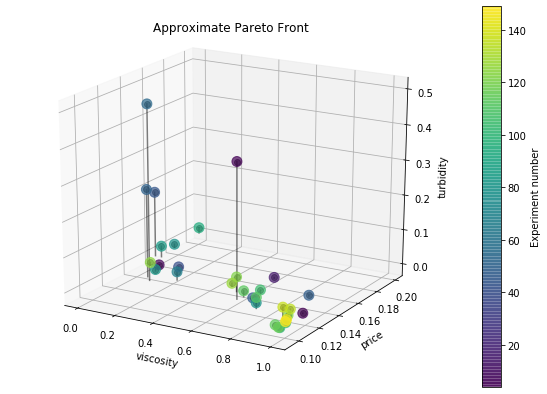

In [10]:
_ = plt.tight_layout()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
pareto_front, indices = pareto_efficient(data[['viscosity', 'price', 'turbidity']].to_numpy(),
                                  maximize=False)
# ax.scatter(data['viscosity'], data['price'], data['turbidity'], 
#            alpha=0.1, label='all data', marker='^', s=50)
img = ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], 
                 alpha=0.7, label='pareto front', s=100, c=data.index[indices])
_ = plt.colorbar(img, label='Experiment number')
ax.set_xlabel('viscosity'); ax.set_ylabel('price'); ax.set_zlabel('turbidity')
for xi, yi, zi in pareto_front:        
    line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), 
                      marker='o', markevery=(1, 1), c='k',alpha=0.5)
    _ = ax.add_line(line)
_ = ax.view_init(20, -60)
_ = ax.set_title('Approximate Pareto Front')

## 3. Run Optimization

Now, we can run the optimization, asking for 3 experimental suggestions.

In [14]:
num_experiments=3
input_dim = domain.num_continuous_dimensions() + domain.num_discrete_variables()
models = {'viscosity': GPyModel(input_dim=input_dim), 
          'price': AnalyticalModel(function=price_function),
          'turbidity': GPyModel(input_dim=input_dim)
         }
tsemo = TSEMO2(domain, models)
experiments = tsemo.generate_experiments(data, num_experiments)
experiments


,Texapon,DehytonAB30,Plantacare818,CC7BZ,ArlyponTT,viscosity,price,turbidity
909,14.578243,12.196873,14.225356,1.567064,1.488452,0.873434,0.389697,0.067679
338,9.247555,14.242010,1.342217,0.835808,1.781791,2.391728,0.245364,0.075804
464,12.946067,12.373749,4.461493,0.821177,1.006975,1.272252,0.297063,0.071012


We now have experimental suggestions that we can run in the lab.

## 4. Validate Model

We'll make a cross validation plot next. This gives us a sense of model robustness. So far, it seems that the model has a very good accuracy in one part of the space, but not great accuracy elsewhere. 

 /Users/Kobi/Documents/Research/summit-demo/summit-demo/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


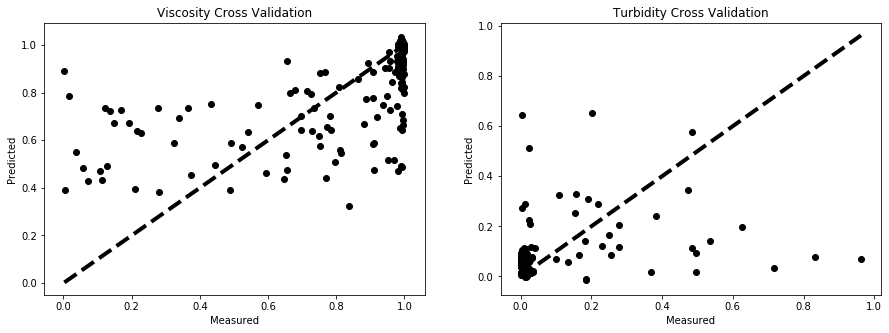

In [17]:
gp = GPyModel(input_dim=input_dim)
X = data[input_columns].to_numpy(dtype=np.float64)
Y = data[output_columns].to_numpy(dtype=np.float64)

#Mask out weird data
mask = np.ones(X.shape[0],dtype=bool)
indices = np.where(Y[:, 0]>1.0)[0]
mask[indices] = 0
# Y = Y[mask, :]
X = X[mask, :]


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, name in enumerate(['viscosity', 'turbidity']):
    kf = KFold(n_splits=3)
    scores = np.zeros(5)

    Y = data[name].to_numpy(dtype=np.float64)
    Y = Y[mask]
    for train, test in kf.split(X):
        gp.fit(X[train], np.atleast_2d(Y[train]).T)
        y_predict = gp.predict(X[test])
        axes[i].scatter(Y[test], y_predict, c='k')
    min_y = Y.min()
    max_y = Y.max()
    axes[i].plot([min_y, max_y], [min_y, max_y], 'k--', lw=4)
    axes[i].set_xlabel('Measured')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{name} Cross Validation'.title())